In [10]:
import pickle


def load_data():
    with open("../../Data/dumped/X_train.pkl", "rb") as f:
        X_train = pickle.load(f)
    with open("../../Data/dumped/y_train.pkl", "rb") as f:
        y_train = pickle.load(f)
    with open("../../Data/dumped/X_test.pkl", "rb") as f:
        X_test = pickle.load(f)
    with open("../../Data/dumped/y_test.pkl", "rb") as f:
        y_test = pickle.load(f)

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = load_data()

In [11]:
import numpy as np


# Функция для анализа распределения классов
def analyze_class_distribution(y, label=""):
    class_counts = np.unique(y[0], return_counts=True)
    print(
        f"{label} class distribution: {dict(zip(class_counts[0].astype(object), class_counts[1].astype(object)))}"
    )


print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

analyze_class_distribution(y_train, "Train")
analyze_class_distribution(y_test, "Test")

Train data shape: (190, 8, 5000)
Test data shape: (48, 8, 5000)
Train class distribution: {0.0: 124, 1.0: 66}
Test class distribution: {0.0: 40, 1.0: 8}


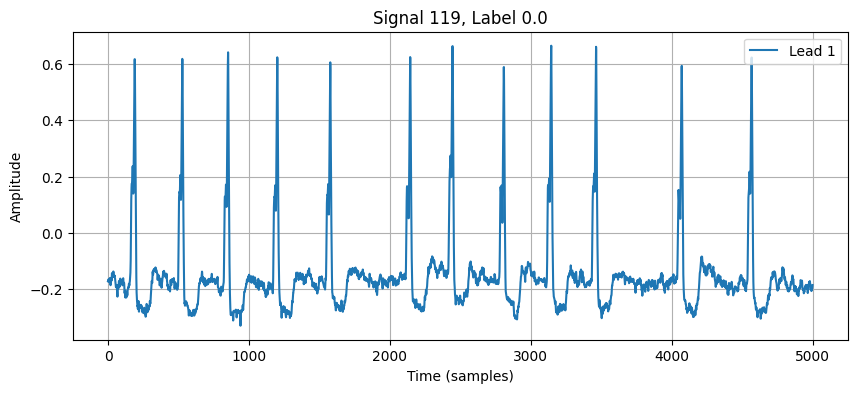

In [34]:
import matplotlib.pyplot as plt


# Функция для отображения сигнала
def plot_signal(signal, title, lead_index):
    plt.figure(figsize=(10, 4))
    plt.plot(signal[lead_index], label=f"Lead {lead_index + 1}")
    plt.title(title)
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()


# Пример использования
signal_index = 119  # Укажите индекс сигнала для визуализации
lead_index = 0  # Укажите индекс отведения (0 - первое отведение, 1 - второе и т.д.)

# Проверяем, что индекс сигнала корректен
if signal_index < len(X_train):
    signal = X_train[signal_index]
    label = y_train[0][signal_index]
    metadata = y_train[1][signal_index]

    plot_signal(signal, f"Signal {signal_index}, Label {label}", lead_index)
else:
    print(f"Signal index {signal_index} is out of range.")

In [42]:
from torchview import draw_graph
import torch.nn.functional as F
from torch import stack

In [40]:
import torch.nn as nn


class ECGNet(nn.Module):
    def __init__(self):
        super(ECGNet, self).__init__()

        # Сверточные слои
        self.conv1 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=7, padding=3)
        self.conv2 = nn.Conv1d(
            in_channels=16, out_channels=32, kernel_size=5, padding=2
        )
        self.pool = nn.MaxPool1d(kernel_size=2)

        # LSTM слой для захвата временных зависимостей
        self.lstm = nn.LSTM(
            input_size=32,
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
        )

        # Полносвязные слои
        self.fc1 = nn.Linear(64 * 2, 128)
        self.fc2 = nn.Linear(128, 3)  # Предполагается 3 класса болезней

    def forward(self, x):
        # x shape: [batch_size, 8, seq_len]

        # Свертка
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))

        # Подготовка для LSTM
        # Меняем размер на [batch_size, seq_len, channels] для LSTM
        x = x.permute(0, 2, 1)

        # LSTM
        x, (hn, cn) = self.lstm(x)

        # Берем последнее скрытое состояние LSTM
        x = x[:, -1, :]  # [batch_size, 64*2]

        # Полносвязные слои
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # [batch_size, num_classes]

        return x

In [43]:
class MultiBranchECGNet(nn.Module):
    def __init__(self, num_channels=8, num_classes=3):
        super(MultiBranchECGNet, self).__init__()

        # Ветви для каждого канала (CNN)
        self.branches = nn.ModuleList(
            [self.create_branch() for _ in range(num_channels)]
        )

        # Attention слой для агрегации информации между каналами
        self.attention = nn.MultiheadAttention(
            embed_dim=128, num_heads=8, batch_first=True
        )

        # Линейный слой для выравнивания размерности перед attention
        self.linear_attn = nn.Linear(num_channels * 128, 128)

        # Полносвязные слои для классификации
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.drop = nn.Dropout(p=0.2)

    def create_branch(self):
        """Создаем сверточную ветвь для каждого канала"""
        branch = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),  # Свертка с padding
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),  # Вторая сверточная операция
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),  # Третья сверточная операция
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        return branch

    def forward(self, x):
        # x shape: [batch_size, num_channels, seq_len]

        # Обрабатываем каждый канал через свою ветвь (CNN для каждого канала)
        branch_outputs = []
        for i in range(x.size(1)):  # num_channels
            branch_output = self.branches[i](
                x[:, i : i + 1, :]
            )  # Обрабатываем i-й канал, [batch_size, 1, seq_len]
            branch_outputs.append(branch_output)

        # Объединяем выходы ветвей
        out = stack(
            branch_outputs, dim=1
        )  # [batch_size, num_channels, 128, reduced_seq_len]

        # out = out.mean(dim=-1)  # Усредняем по временной оси: [batch_size, num_channels, 128]

        # # Применяем multi-head attention для межканальной агрегации
        # out, _ = self.attention(out, out, out)  # [batch_size, num_channels, 128]

        # # Flatten the output
        # out = torch.flatten(out, start_dim=1, end_dim=2)  # [batch_size, num_channels * 128]

        # Меняем форму, чтобы соответствовать входу MultiheadAttention: [batch_size, reduced_seq_len, num_channels * 128]
        batch_size, num_channels, embed_dim, seq_len = out.shape
        out = out.permute(0, 3, 1, 2).reshape(batch_size, seq_len, -1)

        out = F.relu(self.linear_attn(out))

        # Применяем Multihead Attention ко всей последовательности
        out, _ = self.attention(
            out, out, out
        )  # [batch_size, seq_len, num_channels * 128]

        # Усредняем по временной оси
        out = out.mean(dim=1)  # [batch_size, num_channels * 128]

        # Полносвязные слои для классификации
        out = F.relu(self.drop(self.fc1(out)))
        out = self.fc2(out)  # [batch_size, num_classes]
        return out


# Пример использования
model = MultiBranchECGNet(num_channels=8, num_classes=2)

In [44]:
save_folder = "/home/kravchenko.artem/Projects/Diplomas/Classifiers/NN/pictures"
draw_graph(
    model,
    input_size=(1, 8, 5000),
    expand_nested=True,
    roll=True,
    graph_dir="TB",
    filename=f"model_",
    directory=str(save_folder),
    save_graph=True,
)

In [ ]:
import os
import yaml
from clearml import Task
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from docx import Document
from docx.shared import Inches
from sklearn.metrics import recall_score, accuracy_score, precision_score
import json

# Настройка ClearML
CLEARML_PROJECT_NAME = "Diploma Multibranch net/Fractions"
SAVE_DIR = "./results"
os.makedirs(SAVE_DIR, exist_ok=True)

# def fetch_task_data(project_name, task_name):
#     """Загрузка данных из ClearML."""
#     task = Task.get_task(project_name=project_name, task_name=task_name)
#     metrics = task.get_reported_scalars()
#     config = task.artifacts['Config File'].get_local_copy()
#     config = yaml.safe_load(Path(config).read_text())
# #    model weights = StorageManager.get_local_copy(task.get_models()["output"][0].get_local_copy(), 'Config File')
#     return config, metrics


def get_config(task):
    config = task.artifacts["Config File"].get_local_copy()
    config = yaml.safe_load(Path(config).read_text())
    return config


def fetch_all_tasks(project_name):
    """Получение всех задач проекта."""
    tasks = Task.get_tasks(project_name=project_name)
    return tasks


def extract_confusion_matrix(task):
    """Извлечение данных матрицы неточности из логов."""
    logger = task.get_logger()

    # Получение всех графиков
    plots = task.get_reported_plots()
    confusion_matrix_key = None

    # Найти график, связанный с матрицей неточности
    for plot_data in plots:
        if "Confusion Matrix" in plot_data["metric"]:
            confusion_matrix_key = plot_data
            break

    if not confusion_matrix_key:
        raise ValueError(f"No confusion matrix found for task {task.name}")

    matrix = json.loads(confusion_matrix_key["plot_str"])["data"][0]["z"]
    # Получить последний отчет о матрице неточности
    # confusion_data = logger.get_plot(confusion_matrix_key)[-1]  # Последний элемент
    # conf_matrix = confusion_data["data"]
    # labels = confusion_data["layout"]["xaxis"]["ticktext"]

    return matrix


def calculate_metrics(conf_matrix):
    """Рассчитывает precision и recall по матрице."""
    TN, FP = conf_matrix[0]
    FN, TP = conf_matrix[1]
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)
    return precision, recall, specificity, sensitivity


def generate_report(tasks, metrics_table, config_table, output_path):
    """Создание документа .docx."""
    doc = Document()
    doc.add_heading("ClearML Analysis Report", level=1)

    # Добавление таблицы метрик
    doc.add_heading("Metrics Summary", level=2)
    table = doc.add_table(rows=1, cols=len(metrics_table.columns))
    table.style = "Table Grid"

    # Заголовки таблицы
    hdr_cells = table.rows[0].cells
    for i, column_name in enumerate(metrics_table.columns):
        hdr_cells[i].text = column_name

    # Данные таблицы
    for _, row in metrics_table.iterrows():
        row_cells = table.add_row().cells
        for i, value in enumerate(row):
            row_cells[i].text = str(value)

    doc.add_heading("Run Configs", level=2)
    table = doc.add_table(rows=1, cols=len(config_table.columns))
    table.style = "Table Grid"

    # Заголовки таблицы
    hdr_cells = table.rows[0].cells
    for i, column_name in enumerate(config_table.columns):
        hdr_cells[i].text = column_name

    # Данные таблицы
    for _, row in config_table.iterrows():
        row_cells = table.add_row().cells
        for i, value in enumerate(row):
            row_cells[i].text = str(value)

    # Сохранение документа
    doc.save(output_path)


def main():
    tasks = fetch_all_tasks(CLEARML_PROJECT_NAME)
    results = []
    configs = []

    for task in tasks:
        try:
            conf_matrix = extract_confusion_matrix(task)
            precision, recall, specificity, sensitivity = calculate_metrics(conf_matrix)

            # Извлечение конфигурации
            config = get_config(task)
            config_str = ", ".join([f"{k}: {v}" for k, v in config.items()])

            # Добавляем данные в таблицу
            results.append(
                {
                    "Task Name": task.name,
                    "Precision": "{:.3f}".format(precision),
                    "Recall": "{:.3f}".format(recall),
                    "Specificity": "{:.3f}".format(specificity),
                    "Sensitivity": "{:.3f}".format(sensitivity),
                    # "Classes Distribution": f'{config["dataset"]["class_distribution"]}',
                }
            )
            configs.append(
                {
                    "Task Name": task.name,
                    # "Classes Distribution": f'{config["dataset"]["class_distribution"]}',
                    "Loss function": f'{config["loss_function"]["type"]}',
                    "Loss parameters": f'{config["loss_function"]["parameters"]}',
                    "Optimizer parameters": f'{config["optimizer"]["parameters"]}',
                    "Optimizer type": f'{config["optimizer"]["type"]}',
                    "dropout_rate": f'{config["model"]["parameters"]["dropout_rate"]}',
                }
            )
        except Exception as e:
            print(f"Error processing task {task.name}: {e}")

    # Генерация таблицы и документа
    metrics_table = pd.DataFrame(results)
    configs_table = pd.DataFrame(configs)
    output_docx = os.path.join(SAVE_DIR, "report.docx")
    generate_report(tasks, metrics_table, configs_table, output_docx)
    print(f"Report saved to {output_docx}")


if __name__ == "__main__":
    main()

Error processing task Run-c421664e: 'class_distribution'
Report saved to ./results/report.docx
